In [49]:
import optuna
from optuna.samplers import TPESampler
import pickle
from google.colab import drive
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, precision_recall_curve,
    accuracy_score, precision_score, recall_score, f1_score
)

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
data = pd.read_csv('data.csv')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                object 
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           object 
 7   Vehicle_Damage        object 
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
 11  Response              int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 1.0+ GB
None


In [ ]:
print(data.Gender.unique(), data.Vehicle_Age.unique(), data.Vehicle_Damage.unique())

['Male' 'Female'] ['1-2 Year' '> 2 Years' '< 1 Year'] ['Yes' 'No']


In [ ]:
print(data.describe())

                 id           Age  Driving_License   Region_Code  \
count  1.150480e+07  1.150480e+07     1.150480e+07  1.150480e+07   
mean   5.752398e+06  3.838356e+01     9.980220e-01  2.641869e+01   
std    3.321149e+06  1.499346e+01     4.443120e-02  1.299159e+01   
min    0.000000e+00  2.000000e+01     0.000000e+00  0.000000e+00   
25%    2.876199e+06  2.400000e+01     1.000000e+00  1.500000e+01   
50%    5.752398e+06  3.600000e+01     1.000000e+00  2.800000e+01   
75%    8.628598e+06  4.900000e+01     1.000000e+00  3.500000e+01   
max    1.150480e+07  8.500000e+01     1.000000e+00  5.200000e+01   

       Previously_Insured  Annual_Premium  Policy_Sales_Channel       Vintage  \
count        1.150480e+07    1.150480e+07          1.150480e+07  1.150480e+07   
mean         4.629966e-01    3.046137e+04          1.124254e+02  1.638977e+02   
std          4.986289e-01    1.645475e+04          5.403571e+01  7.997953e+01   
min          0.000000e+00    2.630000e+03          1.000000e+00

In [ ]:
print(data.isna().mean())

id                      0.000000
Gender                  0.000000
Age                     0.000000
Driving_License         0.000000
Region_Code             0.000000
Previously_Insured      0.000000
Vehicle_Age             0.000000
Vehicle_Damage          0.000000
Annual_Premium          0.000000
Policy_Sales_Channel    0.000000
Vintage                 0.000002
Response                0.000002
dtype: float64


In [13]:
# Устраянем пропущенные элементы и дубликаты
data = data.dropna()
data = data.drop_duplicates()

# Удаляем ненужные столбцы
data = data.drop(columns=['id'])

# Применяем метод one-hot-encode
data = pd.get_dummies(
    data, columns=['Gender', 'Vehicle_Damage'],
    drop_first=True,
    )
data = data.rename(columns={'Gender_Male': 'Male', 'Vehicle_Damage_Yes': 'Vehicle_Damage'})
data['Male'] = data['Male'].astype(int)
data['Vehicle_Damage'] = data['Vehicle_Damage'].astype(int)

# Применяем OrdinalEncoder к признакам с иерархией
ordinalencoder = OrdinalEncoder(categories = [['< 1 Year', '1-2 Year', '> 2 Years']])
data['Vehicle_Age'] = ordinalencoder.fit_transform(data['Vehicle_Age'].to_frame())

print(data.head())

   Age  Driving_License  Region_Code  Previously_Insured  Vehicle_Age  \
0   21                1         35.0                   0          1.0   
1   43                1         28.0                   0          2.0   
2   25                1         14.0                   1          0.0   
3   35                1          1.0                   0          1.0   
4   36                1         15.0                   1          1.0   

   Annual_Premium  Policy_Sales_Channel  Vintage  Response  Male  \
0         65101.0                 124.0      187         0     1   
1         58911.0                  26.0      288         1     1   
2         38043.0                 152.0      254         0     0   
3          2630.0                 156.0       76         0     0   
4         31951.0                 152.0      294         0     0   

   Vehicle_Damage  
0               1  
1               1  
2               0  
3               1  
4               0  


In [14]:
y = data['Response']
X = data.drop(columns=['Response'])

# Стандартизация
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Разделение данных
(X_train, X_test,
y_train, y_test) = train_test_split(X, y, train_size=0.5, stratify=y, random_state=42)

In [ ]:
def objective_knn(trial):

    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 3, 31),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'p': trial.suggest_int('p', 1, 2)
    }

    knn = KNeighborsClassifier(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(knn, X_train, y_train, cv=skf, scoring='roc_auc')

    return scores.mean()

def objective_dt(trial):

    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy'])
    }

    dt = DecisionTreeClassifier(**params, random_state=42)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(dt, X_train, y_train, cv=skf, scoring='roc_auc')

    return scores.mean()


def objective_rf(trial):

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    }

    rf = RandomForestClassifier(**params, random_state=42)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(rf, X_train, y_train, cv=skf, scoring='roc_auc')

    return scores.mean()

In [ ]:
# Поиск оптимальных гиперпараметров
study_knn = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_knn.optimize(objective_knn, n_trials=5, n_jobs=-1)
print("Лучшие параметры KNN:", study_knn.best_params, "Score:", study_knn.best_value)

study_dt = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_dt.optimize(objective_dt, n_trials=5, n_jobs=-1)
print("Лучшие параметры DT:", study_dt.best_params, "Score:", study_dt.best_value)

study_rf = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_rf.optimize(objective_rf, n_trials=5, n_jobs=-1)
print("Лучшие параметры RF:", study_rf.best_params, "Score:", study_rf.best_value)

[I 2025-12-07 13:36:32,841] A new study created in memory with name: no-name-4bed8fe4-6e12-4d34-b91f-1cb74d72f13d
[I 2025-12-07 13:38:20,847] Trial 1 finished with value: 0.8047399171843601 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 0.8047399171843601.
[I 2025-12-07 13:39:09,331] Trial 0 finished with value: 0.7909311362670481 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'p': 1}. Best is trial 1 with value: 0.8047399171843601.
[I 2025-12-07 13:40:55,984] Trial 2 finished with value: 0.8400915297218091 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'p': 2}. Best is trial 2 with value: 0.8400915297218091.
[I 2025-12-07 13:42:51,962] Trial 3 finished with value: 0.838058472600547 and parameters: {'n_neighbors': 23, 'weights': 'uniform', 'p': 1}. Best is trial 2 with value: 0.8400915297218091.
[I 2025-12-07 13:43:37,591] Trial 4 finished with value: 0.8283740389358103 and parameters: {'n_neighbors': 16, 'weights': '

Лучшие параметры KNN: {'n_neighbors': 30, 'weights': 'uniform', 'p': 2} Score: 0.8400915297218091


[I 2025-12-07 13:43:41,280] Trial 1 finished with value: 0.8303540811923285 and parameters: {'max_depth': 13, 'min_samples_split': 16, 'min_samples_leaf': 4, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8303540811923285.
[I 2025-12-07 13:43:41,847] Trial 0 finished with value: 0.7893737047537546 and parameters: {'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 9, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8303540811923285.
[I 2025-12-07 13:43:46,085] Trial 3 finished with value: 0.8490611578234712 and parameters: {'max_depth': 8, 'min_samples_split': 19, 'min_samples_leaf': 5, 'criterion': 'gini'}. Best is trial 3 with value: 0.8490611578234712.
[I 2025-12-07 13:43:47,038] Trial 2 finished with value: 0.7922527050357344 and parameters: {'max_depth': 18, 'min_samples_split': 17, 'min_samples_leaf': 8, 'criterion': 'entropy'}. Best is trial 3 with value: 0.8490611578234712.
[I 2025-12-07 13:43:48,830] Trial 4 finished with value: 0.8242327952257449 and p

Лучшие параметры DT: {'max_depth': 8, 'min_samples_split': 19, 'min_samples_leaf': 5, 'criterion': 'gini'} Score: 0.8490611578234712


[I 2025-12-07 13:44:33,308] Trial 0 finished with value: 0.8597214209294528 and parameters: {'n_estimators': 51, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 0 with value: 0.8597214209294528.
[I 2025-12-07 13:47:23,855] Trial 1 finished with value: 0.8578420505416048 and parameters: {'n_estimators': 281, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8597214209294528.
[I 2025-12-07 13:48:33,217] Trial 2 finished with value: 0.8589354164425259 and parameters: {'n_estimators': 295, 'max_depth': 9, 'min_samples_split': 12, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8597214209294528.
[I 2025-12-07 13:49:48,611] Trial 4 finished with value: 0.8423655697570505 and parameters: {'n_estimators': 193, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 0.8597214209294528

Лучшие параметры RF: {'n_estimators': 206, 'max_depth': 20, 'min_samples_split': 17, 'min_samples_leaf': 8, 'max_features': 'sqrt'} Score: 0.8600731289930856


In [ ]:
knn_best_params = {'n_neighbors': 30, 'weights': 'uniform', 'p': 2}
dt_best_params = {'max_depth': 8, 'min_samples_split': 19, 'min_samples_leaf': 5, 'criterion': 'gini'}
rf_best_params = {'n_estimators': 206, 'max_depth': 20, 'min_samples_split': 17, 'min_samples_leaf': 8, 'max_features': 'sqrt'}

models = {
    'kNC': KNeighborsClassifier(**knn_best_params, n_jobs=-1, verbose=2),
    'DFC': DecisionTreeClassifier(**dt_best_params, random_state=42),
    'RFC': RandomForestClassifier(**rf_best_params, random_state=42, n_jobs=-1, verbose=2)
}

y_proba = {}
for name, model in models.items():
  model.fit(X_train, y_train)
  y_proba[name] = model.predict_proba(X_test)

In [ ]:
# Сохранение промежуточных результатов
save_path = '/content/drive/MyDrive/Colab Notebooks/models_and_probabilities.pkl'
with open(save_path, 'wb') as f:
  pickle.dump({
      'models': models,
      'y_proba': y_proba
  }, f)

In [9]:
# Загрузка результатов
save_path = '/content/drive/MyDrive/Colab Notebooks/models_and_probabilities.pkl'
with open(save_path, 'rb') as f:
  out = pickle.load(f)
  models = out['models']
  y_proba = out['y_proba']

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.7.2 when using version 1.6.1. This might lea

In [39]:
# Поиск оптимального порога, при котором f1-метрика максимальна
for name, proba in y_proba.items():
  precision, recall, thresholds = precision_recall_curve(y_test, proba[:, 1])
  f1 = (2 * precision * recall) / (precision + recall)
  f1 = np.nan_to_num(f1)
  print(f'Максимальная f1-метрика = {f1.max()} у модели {name} достигается при threshold = {thresholds[np.argmax(f1)]}')

/tmp/ipython-input-3143458064.py:4: RuntimeWarning: invalid value encountered in divide
  f1 = (2 * precision * recall) / (precision + recall)


Максимальная f1-метрика = 0.4492698138203209 у модели kNC достигается при threshold = 0.23333333333333334


/tmp/ipython-input-3143458064.py:4: RuntimeWarning: invalid value encountered in divide
  f1 = (2 * precision * recall) / (precision + recall)


Максимальная f1-метрика = 0.4557157084905606 у модели DFC достигается при threshold = 0.22537878787878787
Максимальная f1-метрика = 0.4728157140982539 у модели RFC достигается при threshold = 0.24766054929668205


/tmp/ipython-input-3143458064.py:4: RuntimeWarning: invalid value encountered in divide
  f1 = (2 * precision * recall) / (precision + recall)


In [42]:
# Переводим предсказанные значения из вероятностей в 0/1
threshold = {'kNC': 0.233, 'DFC': 0.225, 'RFC': 0.248}
y_pred = {}

for name, proba in y_proba.items():
  y_pred[name] = (proba[:, 1] >= threshold[name]).astype(int)

===МЕТРИКИ kNC===
              precision    recall  f1-score   support

     Класс 0       0.95      0.79      0.86   5044870
     Класс 1       0.32      0.73      0.45    707529

    accuracy                           0.78   5752399
   macro avg       0.64      0.76      0.66   5752399
weighted avg       0.88      0.78      0.81   5752399



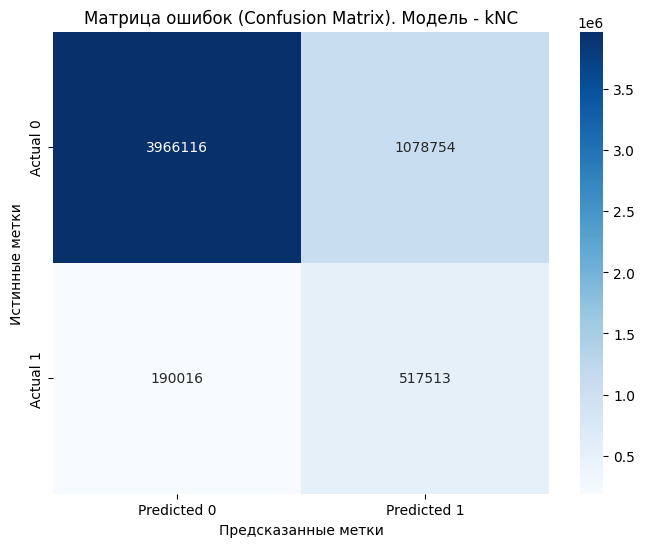

===МЕТРИКИ DFC===
              precision    recall  f1-score   support

     Класс 0       0.96      0.77      0.85   5044870
     Класс 1       0.32      0.79      0.46    707529

    accuracy                           0.77   5752399
   macro avg       0.64      0.78      0.65   5752399
weighted avg       0.88      0.77      0.80   5752399



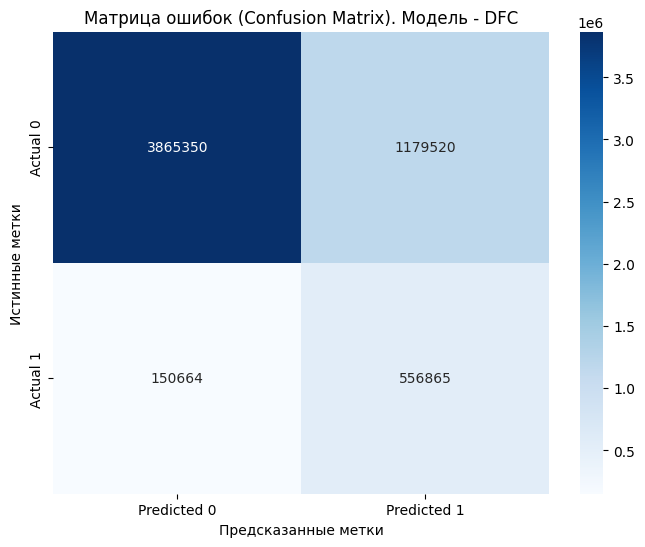

===МЕТРИКИ RFC===
              precision    recall  f1-score   support

     Класс 0       0.96      0.81      0.87   5044870
     Класс 1       0.35      0.74      0.47    707529

    accuracy                           0.80   5752399
   macro avg       0.65      0.77      0.67   5752399
weighted avg       0.88      0.80      0.83   5752399



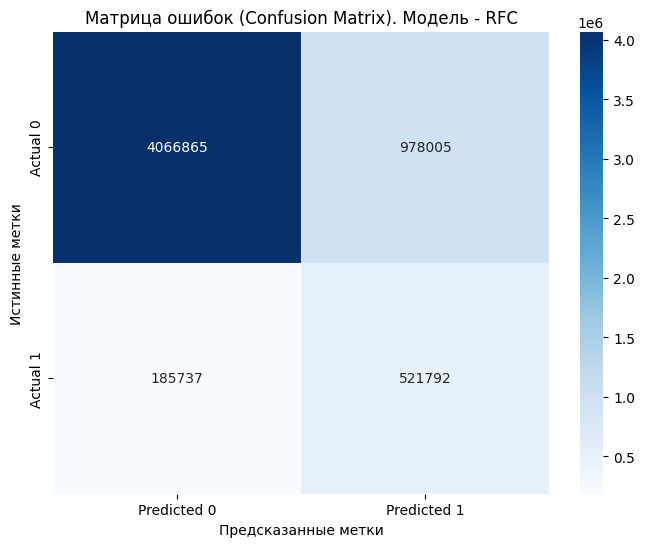

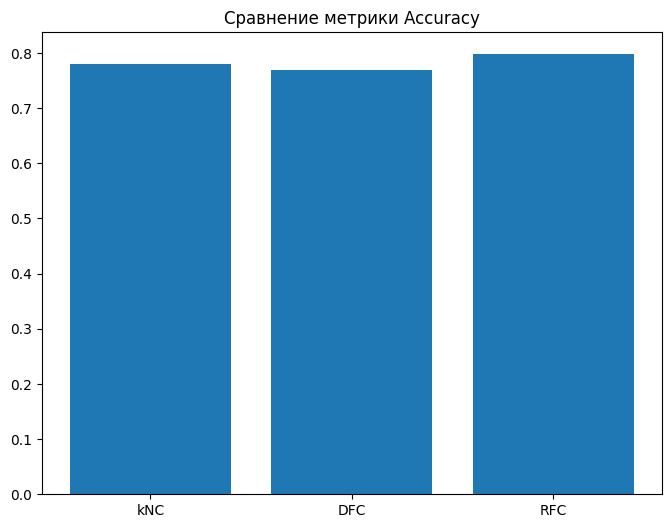

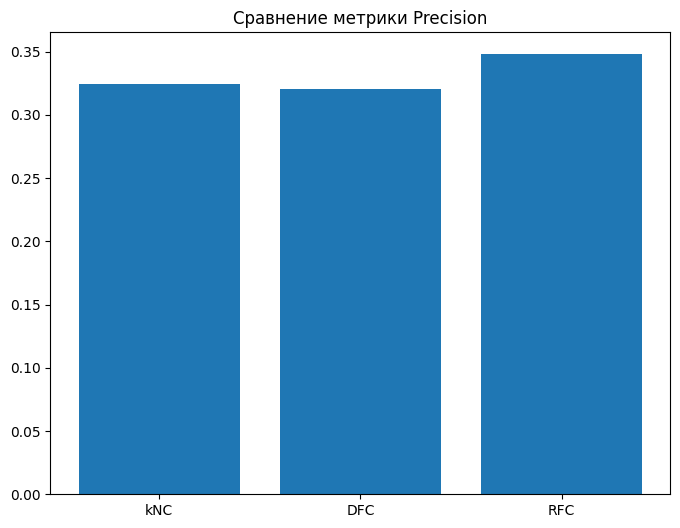

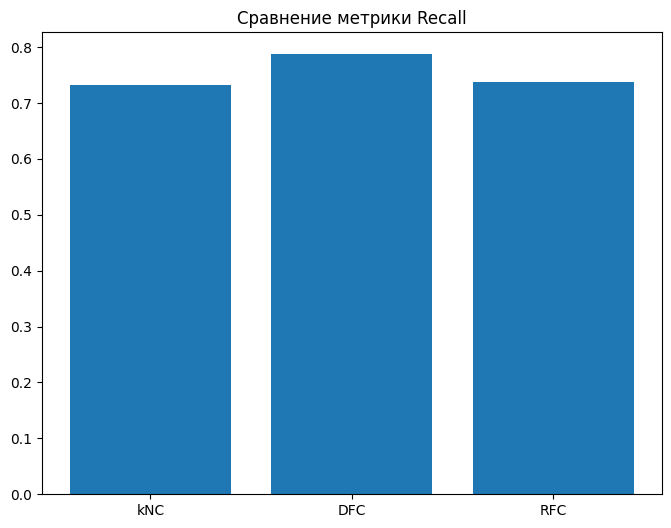

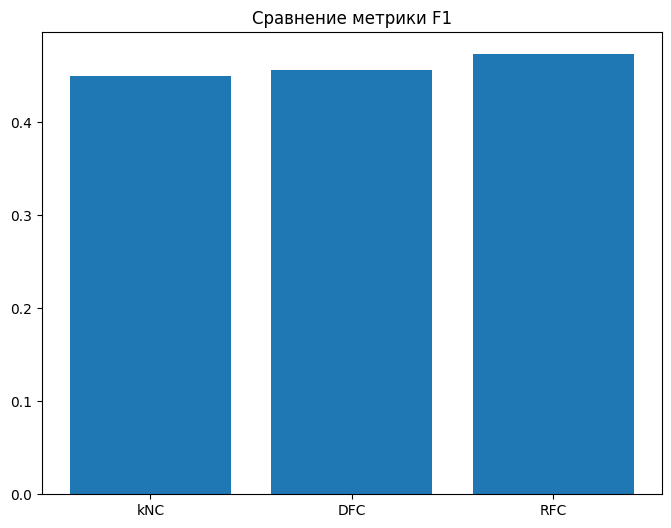

In [50]:
accuracy = {}
precision = {}
recall = {}
f1 = {}

# Вывод метрик и матриц ошибок для каждой модели
for name, pred in y_pred.items():
  print(f'===МЕТРИКИ {name}===')
  accuracy[name] = accuracy_score(y_test, pred)
  precision[name] = precision_score(y_test, pred)
  recall[name] = recall_score(y_test, pred)
  f1[name] = f1_score(y_test, pred)
  print(classification_report(y_test, pred, target_names=['Класс 0', 'Класс 1']))
  cm = confusion_matrix(y_test, pred)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=['Predicted 0', 'Predicted 1'],
              yticklabels=['Actual 0', 'Actual 1'])
  plt.title(f'Матрица ошибок (Confusion Matrix). Модель - {name}')
  plt.ylabel('Истинные метки')
  plt.xlabel('Предсказанные метки')
  plt.show()

# Столбчатые диаграммы для сравнения метрик между моделями
plt.figure(figsize=(8, 6))
plt.bar(accuracy.keys(), accuracy.values())
plt.title(f'Сравнение метрики Accuracy')
plt.show()
plt.figure(figsize=(8, 6))
plt.bar(precision.keys(), precision.values())
plt.title(f'Сравнение метрики Precision')
plt.show()
plt.figure(figsize=(8, 6))
plt.bar(recall.keys(), recall.values())
plt.title(f'Сравнение метрики Recall')
plt.show()
plt.figure(figsize=(8, 6))
plt.bar(f1.keys(), f1.values())
plt.title(f'Сравнение метрики F1')
plt.show()

В данной задаче метрика recall важнее (платеж за упущенного клиента, купившего бы страховку, больше, чем за предложение страховки клиенту, который ее не купит). Соответственно лучшая модель - DTC

In [52]:
# Сохранение лучшей модели
save_path = '/content/drive/MyDrive/Colab Notebooks/best_model.pkl'
with open(save_path, 'wb') as f:
  pickle.dump({
      'model': models['DFC'],
      'scaler': scaler
  }, f)